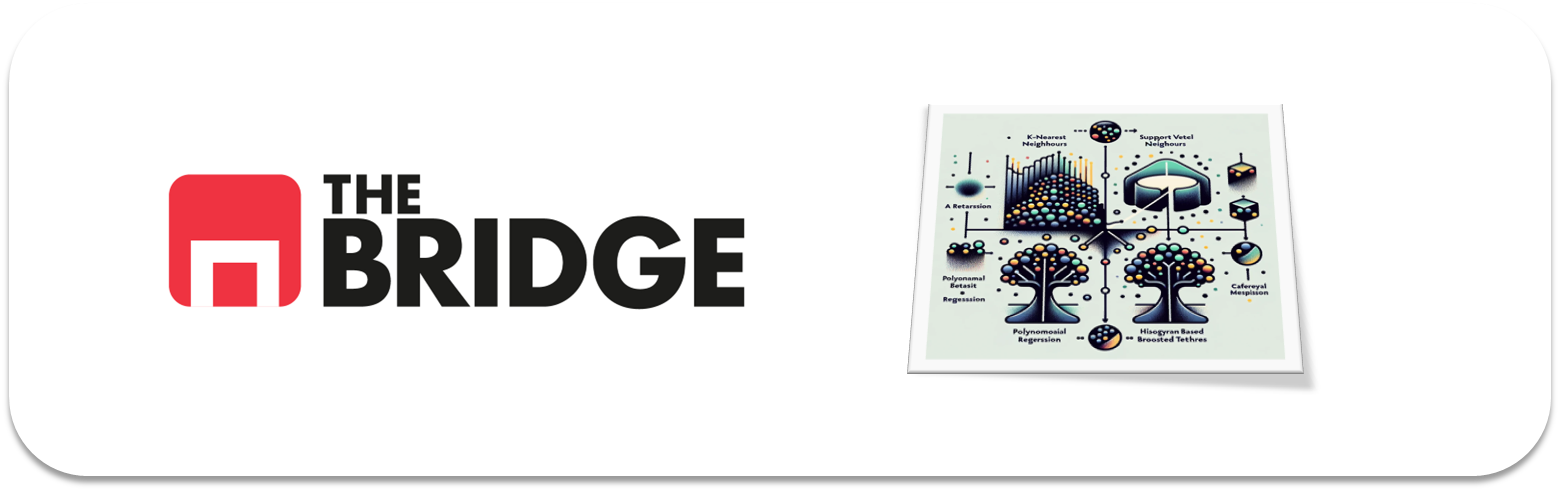

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


from bootcampviztools import *

import warnings
warnings.filterwarnings('ignore')

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
df = pd.read_csv("./data/credit_npo.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [3]:
def calcular_cardinalidad(df):
    cardinalidad = {}
    for columna in df.columns:
        cardinalidad[columna] = len(df[columna].unique()) / len(df) * 100
    return pd.DataFrame(cardinalidad.items(), columns=["Columna", "Cardinalidad (%)"])

cardinalidad = calcular_cardinalidad(df)
print(cardinalidad)

                                 Columna  Cardinalidad (%)
0                       SeriousDlqin2yrs          0.015953
1   RevolvingUtilizationOfUnsecuredLines         85.857861
2                                    age          0.622158
3   NumberOfTime30-59DaysPastDueNotWorse          0.079764
4                              DebtRatio         92.103374
5                          MonthlyIncome         33.245593
6        NumberOfOpenCreditLinesAndLoans          0.342985
7                NumberOfTimes90DaysLate          0.103693
8           NumberRealEstateLoansOrLines          0.127622
9   NumberOfTime60-89DaysPastDueNotWorse          0.063811
10                    NumberOfDependents          0.087740


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

In [4]:
target = "SeriousDlqin2yrs" # Binária
features_num = ["RevolvingUtilizationOfUnsecuredLines", "DebtRatio", "MonthlyIncome"]
features_cat = [cols for cols in df.columns if cols not in features_num + [target]]

In [5]:
# La variable objetivo es **SeriousDlqin2yrs**, binaria. Por lo tanto, se trata de un problema de clasificación.

### #1.3
Pinta la distribución de frecuencias del target y coméntala

In [6]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

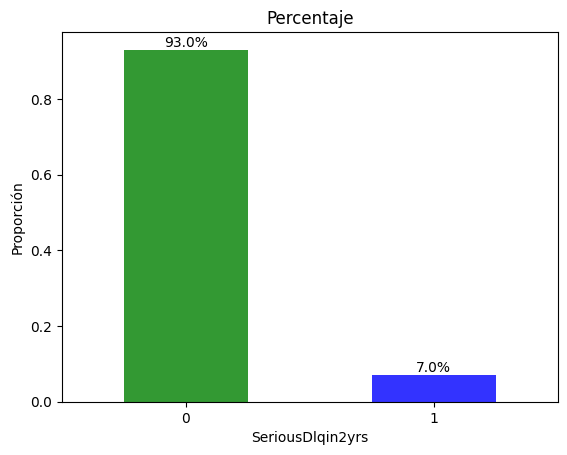

In [7]:
ax = train_set[target].value_counts(normalize=True).plot(
    kind="bar", color=["green", "blue"], alpha=0.8
)

for p in ax.patches:
    percentage = f"{p.get_height() * 100:.1f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xlabel("SeriousDlqin2yrs")
plt.ylabel("Proporción")
plt.title("Percentaje")
plt.xticks(rotation=0)
plt.show()

In [8]:
train_set[target].value_counts()

SeriousDlqin2yrs
0    9328
1     701
Name: count, dtype: int64

In [126]:
# Conjunto de datos extremadamente desequilibrado, será necesario utilizar alguna técnica de sobremuestreo o submuestreo.

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

**Mirando categóricas**

In [10]:
features_cat

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [11]:
# age

In [12]:
train_set["age"].unique()

array([ 51,  73,  28,  40,  61,  22,  56,  78,  65,  48,  32,  38,  84,
        47,  68,  44,  45,  29,  34,  72,  27,  43,  37,  82,  53,  54,
        64,  77,  52,  75,  59,  46,  33,  42,  57,  58,  66,  36,  76,
        62,  49,  83,  41,  55,  30,  69,  50,  67,  31,  60,  79,  71,
        70,  39,  35,  74,  63,  25,  26,  86,  23,  90,  89,  24,  81,
        21,  95,  87,  91, 101,  80,  85,  88,  94,  93,  92,  96,  97],
      dtype=int64)

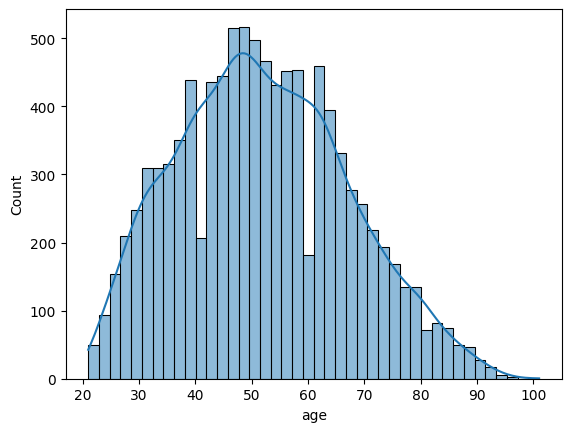

In [13]:
sns.histplot(train_set['age'], kde=True)
plt.show()

In [14]:
bins_age = [0, 30, 40, 50, 60, 70, np.inf] 
labels_age = ["-30", "30-40", "40-50", "50-60","60-70", "70+"]

train_set['age'] = pd.cut(train_set['age'], bins=bins_age, labels=labels_age, right=False)
train_set.sample()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
12230,0,0.945011,30-40,0,0.461933,3900.0,6,0,1,0,0.0


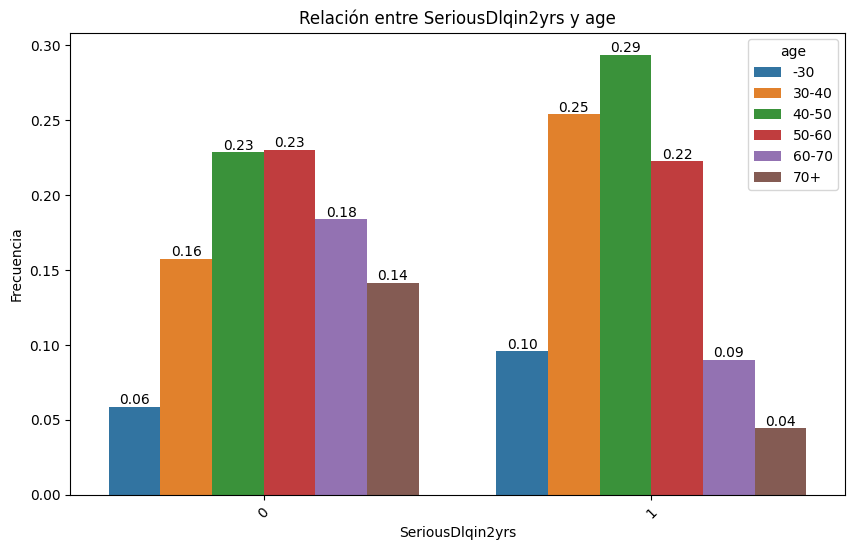

In [15]:
plot_categorical_relationship_fin(train_set, target, "age", show_values=True, relative_freq=True)

In [16]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_encoder_age = OrdinalEncoder(categories=[labels_age])
train_set['age_encoded'] = ordinal_encoder_age.fit_transform(train_set[['age']])

In [17]:
# NumberOfTime30-59DaysPastDueNotWorse

In [18]:
train_set['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

NumberOfTime30-59DaysPastDueNotWorse
0     8399
1     1111
2      319
3      100
4       47
5       19
98      16
6       15
8        2
7        1
Name: count, dtype: int64

In [19]:
bins_NumberOfTime30_59DaysPastDueNotWorse = [0, 1, 2, 3, np.inf] 
labels_NumberOfTime30_59DaysPastDueNotWorse = ["1", "2", "3", "4+"]

train_set['NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(train_set['NumberOfTime30-59DaysPastDueNotWorse'], bins=bins_NumberOfTime30_59DaysPastDueNotWorse, labels=labels_NumberOfTime30_59DaysPastDueNotWorse, right=False)
train_set.sample()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_encoded
10324,0,0.490155,60-70,1,0.366667,8729.0,14,0,1,0,0.0,4.0


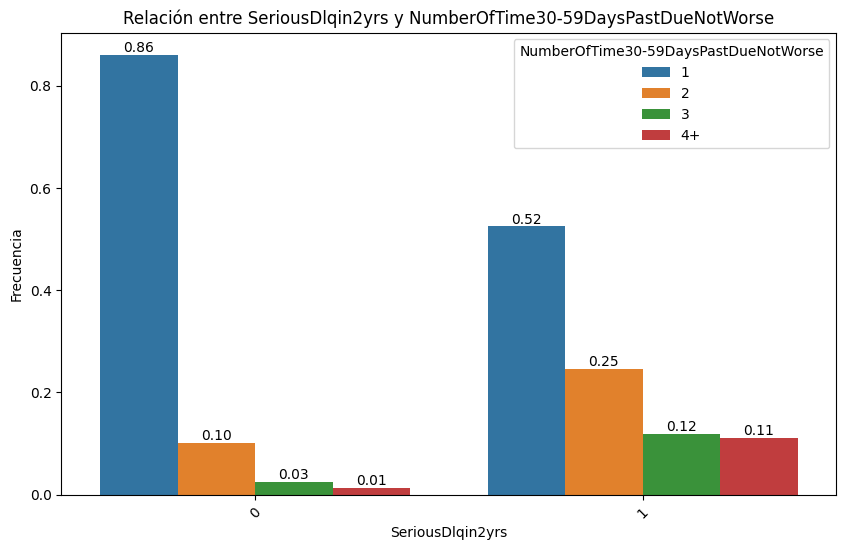

In [20]:
plot_categorical_relationship_fin(train_set, target, "NumberOfTime30-59DaysPastDueNotWorse", show_values=True, relative_freq=True)

In [21]:
ordinal_encoder_NumberOfTime30_59DaysPastDueNotWorse = OrdinalEncoder(categories=[labels_NumberOfTime30_59DaysPastDueNotWorse])
train_set['NumberOfTime30-59DaysPastDueNotWorse_encoded'] = ordinal_encoder_NumberOfTime30_59DaysPastDueNotWorse.fit_transform(train_set[['NumberOfTime30-59DaysPastDueNotWorse']])

In [22]:
# NumberOfOpenCreditLinesAndLoans

In [23]:
train_set['NumberOfOpenCreditLinesAndLoans'].unique()

array([ 6, 12,  4,  2, 15, 10,  9,  5, 16,  7, 11,  3,  1, 14, 25, 21, 18,
        8, 19, 13, 17, 23, 30,  0, 22, 26, 20, 24, 27, 29, 32, 49, 28, 33,
       43, 48, 34, 31, 40, 35, 36], dtype=int64)

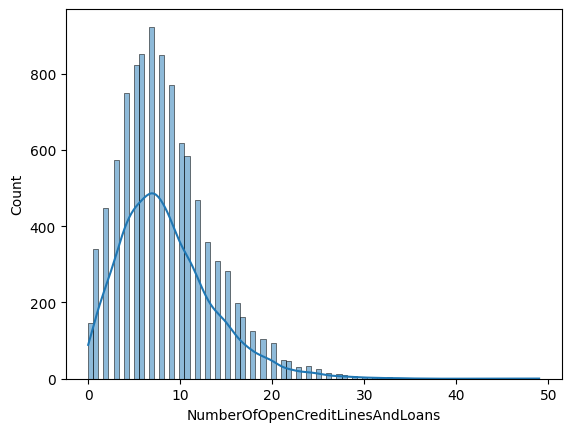

In [24]:
sns.histplot(train_set['NumberOfOpenCreditLinesAndLoans'], kde=True)
plt.show()

In [25]:
bins_NumberOfOpenCreditLinesAndLoans = [0, 5, 10, 15, 20, np.inf] 
labels_NumberOfOpenCreditLinesAndLoans = ["-5", "5-10", "10-15", "15-20", "20+"]

train_set['NumberOfOpenCreditLinesAndLoans'] = pd.cut(train_set['NumberOfOpenCreditLinesAndLoans'], bins=bins_NumberOfOpenCreditLinesAndLoans, labels=labels_NumberOfOpenCreditLinesAndLoans, right=False)
train_set.sample()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_encoded,NumberOfTime30-59DaysPastDueNotWorse_encoded
4307,0,0.047477,60-70,1,0.020552,5400.0,5-10,0,0,0,0.0,4.0,0.0


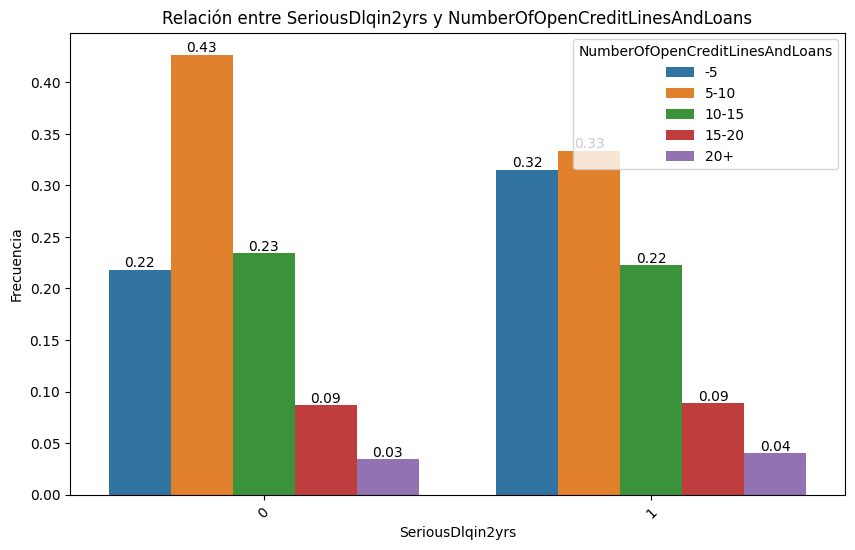

In [26]:
plot_categorical_relationship_fin(train_set, target, "NumberOfOpenCreditLinesAndLoans", show_values=True, relative_freq=True)

In [27]:
ordinal_encoder_NumberOfOpenCreditLinesAndLoans = OrdinalEncoder(categories=[labels_NumberOfOpenCreditLinesAndLoans])
train_set['NumberOfOpenCreditLinesAndLoans_encoded'] = ordinal_encoder_NumberOfOpenCreditLinesAndLoans.fit_transform(train_set[['NumberOfOpenCreditLinesAndLoans']])

In [28]:
# NumberOfTimes90DaysLate

In [29]:
train_set['NumberOfTimes90DaysLate'].unique()

array([ 0,  2,  1,  3, 98,  4,  9,  8,  6,  5, 13,  7, 10], dtype=int64)

In [30]:
train_set['NumberOfTimes90DaysLate'].value_counts()

NumberOfTimes90DaysLate
0     9474
1      333
2      112
3       44
4       27
98      16
5        9
6        5
8        3
7        3
9        1
13       1
10       1
Name: count, dtype: int64

In [31]:
bins_NumberOfTimes90DaysLate = [0, 1, 2, np.inf] 
labels_NumberOfTimes90DaysLate = ["1", "2", "3+"]

train_set['NumberOfTimes90DaysLate'] = pd.cut(train_set['NumberOfTimes90DaysLate'], bins=bins_NumberOfTimes90DaysLate, labels=labels_NumberOfTimes90DaysLate, right=False)
train_set.sample()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_encoded,NumberOfTime30-59DaysPastDueNotWorse_encoded,NumberOfOpenCreditLinesAndLoans_encoded
332,0,0.056932,60-70,1,0.738283,2666.0,5-10,1,1,0,0.0,4.0,0.0,1.0


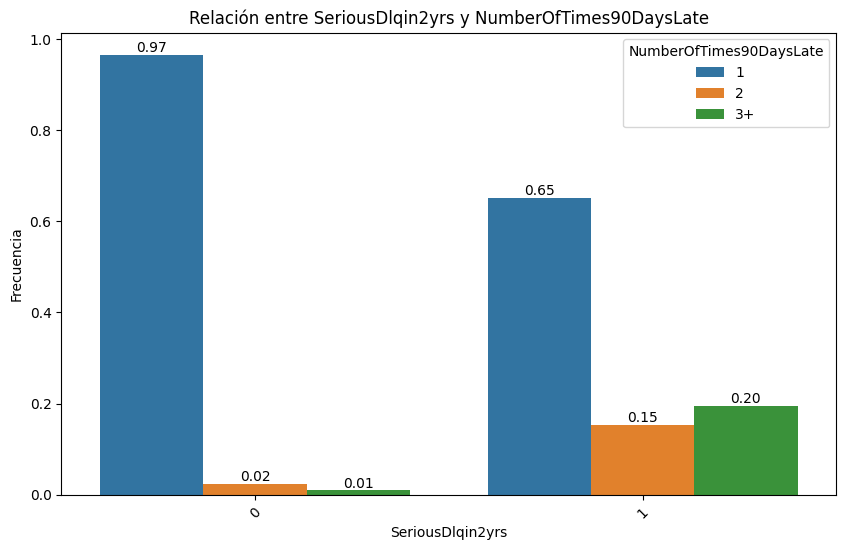

In [32]:
plot_categorical_relationship_fin(train_set, target, "NumberOfTimes90DaysLate", show_values=True, relative_freq=True)

In [33]:
ordinal_encoder_NumberOfTimes90DaysLate = OrdinalEncoder(categories=[labels_NumberOfTimes90DaysLate])
train_set['NumberOfTimes90DaysLate_encoded'] = ordinal_encoder_NumberOfTimes90DaysLate.fit_transform(train_set[['NumberOfTimes90DaysLate']])

In [34]:
# NumberRealEstateLoansOrLines

In [35]:
train_set['NumberRealEstateLoansOrLines'].unique()

array([ 2,  0,  3,  1,  4,  6,  5, 11,  7, 13, 10, 12,  9,  8, 16, 19],
      dtype=int64)

In [36]:
train_set['NumberRealEstateLoansOrLines'].value_counts()

NumberRealEstateLoansOrLines
0     3983
1     3308
2     2059
3      423
4      141
5       60
6       22
7       10
8        8
11       4
9        4
12       2
16       2
13       1
10       1
19       1
Name: count, dtype: int64

In [37]:
bins_NumberRealEstateLoansOrLines = [0, 1, 2, 3, np.inf] 
labels_NumberRealEstateLoansOrLines = ["0", "1", "2", "3+"]

train_set['NumberRealEstateLoansOrLines'] = pd.cut(
    train_set['NumberRealEstateLoansOrLines'], 
    bins=bins_NumberRealEstateLoansOrLines, 
    labels=labels_NumberRealEstateLoansOrLines, 
    right=False
)
train_set.sample()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_encoded,NumberOfTime30-59DaysPastDueNotWorse_encoded,NumberOfOpenCreditLinesAndLoans_encoded,NumberOfTimes90DaysLate_encoded
11187,0,0.280841,50-60,1,0.390559,11439.0,5-10,1,2,0,5.0,3.0,0.0,1.0,0.0


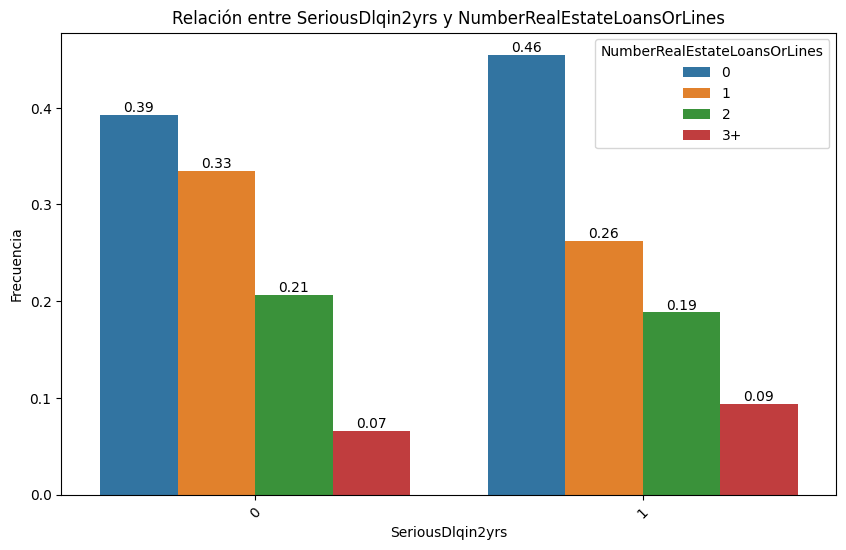

In [38]:
plot_categorical_relationship_fin(train_set, target, "NumberRealEstateLoansOrLines", show_values=True, relative_freq=True)

In [39]:
ordinal_encoder_NumberRealEstateLoansOrLines = OrdinalEncoder(categories=[labels_NumberRealEstateLoansOrLines])
train_set['NumberRealEstateLoansOrLines_encoded'] = ordinal_encoder_NumberRealEstateLoansOrLines.fit_transform(train_set[['NumberRealEstateLoansOrLines']])

In [40]:
# NumberOfTime60-89DaysPastDueNotWorse

In [41]:
train_set['NumberOfTime60-89DaysPastDueNotWorse'].unique()

array([ 0,  1,  2,  4, 98,  5,  3, 11], dtype=int64)

In [42]:
train_set['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()

NumberOfTime60-89DaysPastDueNotWorse
0     9521
1      392
2       70
98      16
4       13
3       12
5        4
11       1
Name: count, dtype: int64

In [43]:
bins_NumberOfTime60_89DaysPastDueNotWorse = [0, 1, 2, np.inf] 
labels_NumberOfTime60_89DaysPastDueNotWorse = ["0", "1", "2+"]

train_set['NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(
    train_set['NumberOfTime60-89DaysPastDueNotWorse'], 
    bins=bins_NumberOfTime60_89DaysPastDueNotWorse, 
    labels=labels_NumberOfTime60_89DaysPastDueNotWorse, 
    right=False
)
train_set.sample()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_encoded,NumberOfTime30-59DaysPastDueNotWorse_encoded,NumberOfOpenCreditLinesAndLoans_encoded,NumberOfTimes90DaysLate_encoded,NumberRealEstateLoansOrLines_encoded
1476,0,0.011071,60-70,2,0.27862,8900.0,20+,1,1,0,3.0,4.0,1.0,4.0,0.0,1.0


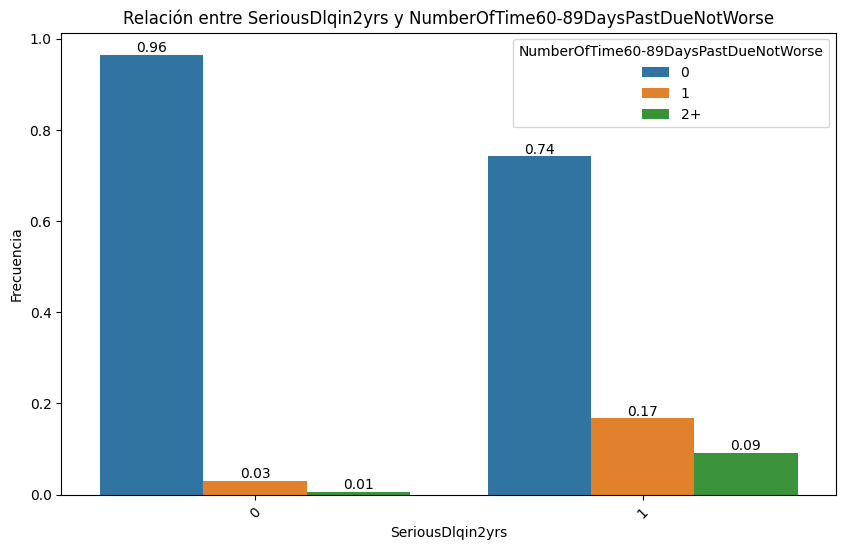

In [44]:
plot_categorical_relationship_fin(train_set, target, "NumberOfTime60-89DaysPastDueNotWorse", show_values=True, relative_freq=True)

In [45]:
ordinal_encoder_NumberOfTime60_89DaysPastDueNotWorse = OrdinalEncoder(categories=[labels_NumberOfTime60_89DaysPastDueNotWorse])
train_set['NumberOfTime60-89DaysPastDueNotWorse_encoded'] = ordinal_encoder_NumberOfTime60_89DaysPastDueNotWorse.fit_transform(train_set[['NumberOfTime60-89DaysPastDueNotWorse']])

In [46]:
# NumberOfDependents

In [47]:
train_set['NumberOfDependents'].unique()

array([ 2.,  0.,  1.,  3.,  4., nan,  5.,  6., 10.,  7.,  8.])

In [48]:
train_set['NumberOfDependents'].value_counts()

NumberOfDependents
0.0     5560
1.0     1898
2.0     1462
3.0      698
4.0      197
5.0       52
6.0       19
10.0       1
7.0        1
8.0        1
Name: count, dtype: int64

In [49]:
bins_NumberOfDependents = [0, 1, 2, 3, 4, np.inf] 
labels_NumberOfDependents = ["0", "1","2" ,"3", "4+"]

train_set['NumberOfDependents'] = pd.cut(
    train_set['NumberOfDependents'], 
    bins=bins_NumberOfDependents, 
    labels=labels_NumberOfDependents, 
    right=False
)
train_set.sample()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_encoded,NumberOfTime30-59DaysPastDueNotWorse_encoded,NumberOfOpenCreditLinesAndLoans_encoded,NumberOfTimes90DaysLate_encoded,NumberRealEstateLoansOrLines_encoded,NumberOfTime60-89DaysPastDueNotWorse_encoded
4002,0,0.0,70+,1,0.044472,10500.0,-5,1,1,0,0,5.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_set['NumberOfDependents'] = train_set['NumberOfDependents'].cat.add_categories("Unknown")
train_set['NumberOfDependents'].fillna("Unknown", inplace=True)

In [51]:
train_set['NumberOfDependents'].value_counts()

NumberOfDependents
0          5560
1          1898
2          1462
3           698
4+          271
Unknown     140
Name: count, dtype: int64

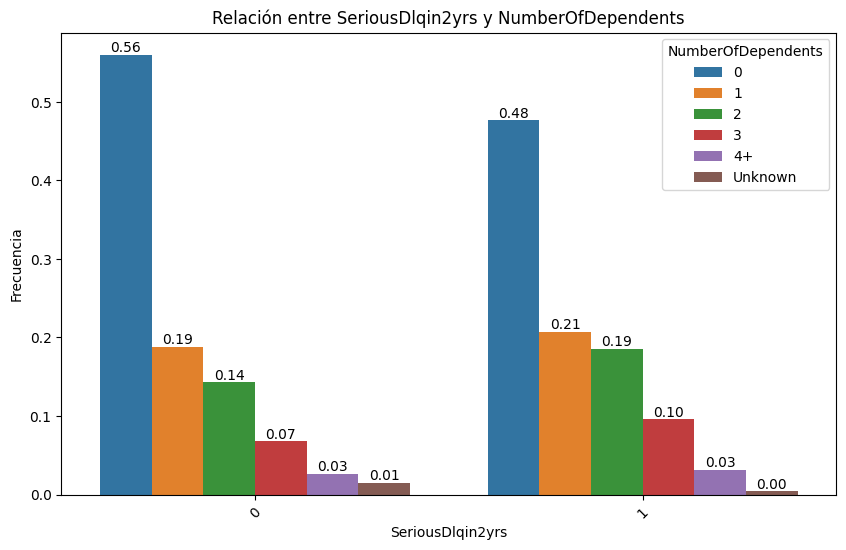

In [52]:
plot_categorical_relationship_fin(train_set, target, "NumberOfDependents", show_values=True, relative_freq=True)

In [53]:
ordinal_encoder_NumberOfDependents = OrdinalEncoder(categories=[labels_NumberOfDependents + ["Unknown"]])
train_set['NumberOfDependents_encoded'] = ordinal_encoder_NumberOfDependents.fit_transform(train_set[['NumberOfDependents']])

**Variables Numéricas**

In [54]:
features_num

['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']

In [55]:
# RevolvingUtilizationOfUnsecuredLines

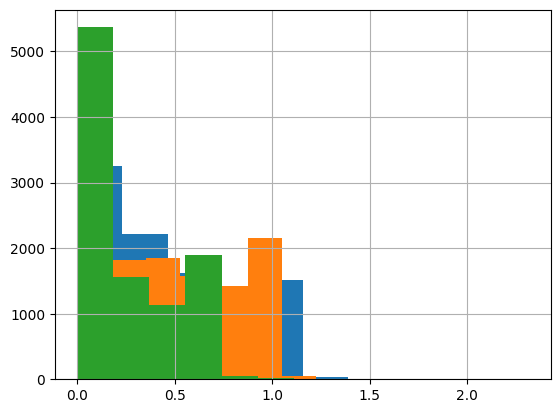

In [56]:
np.sqrt(train_set["RevolvingUtilizationOfUnsecuredLines"]).hist() 
np.cbrt(train_set["RevolvingUtilizationOfUnsecuredLines"]).hist() 
np.log(train_set["RevolvingUtilizationOfUnsecuredLines"] + 1).hist() 
plt.show()

In [57]:
train_set["RevolvingUtilizationOfUnsecuredLines"] = train_set["RevolvingUtilizationOfUnsecuredLines"].apply(np.cbrt)

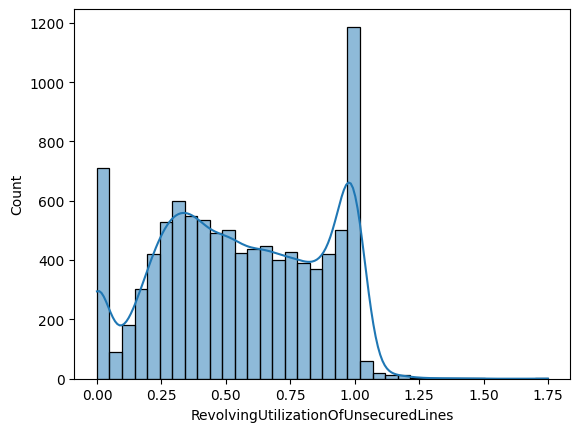

In [58]:
sns.histplot(train_set['RevolvingUtilizationOfUnsecuredLines'], kde=True)
plt.show()

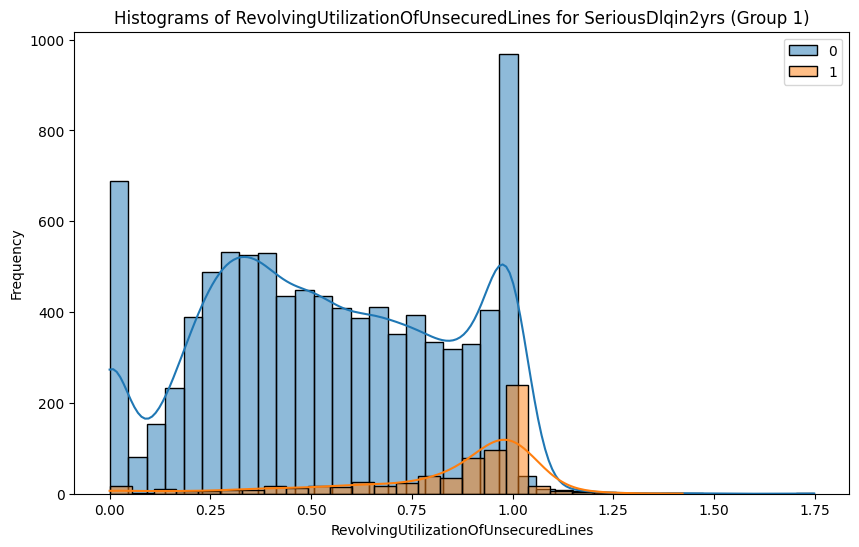

In [59]:
plot_grouped_histograms(train_set, cat_col= target, num_col= "RevolvingUtilizationOfUnsecuredLines", group_size= 2)

In [60]:
# DebtRatio

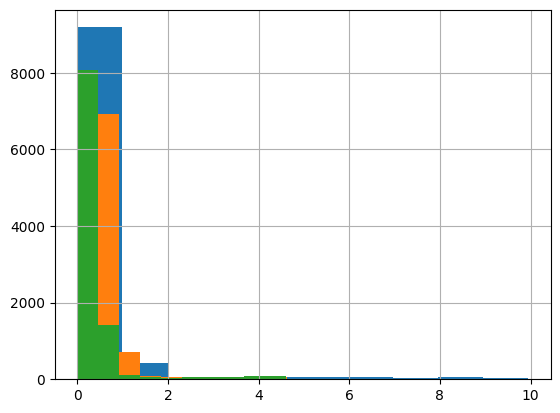

In [61]:
np.sqrt(train_set["DebtRatio"]).hist() 
np.cbrt(train_set["DebtRatio"]).hist() 
np.log(train_set["DebtRatio"] + 1).hist() 
plt.show()

In [62]:
train_set["DebtRatio"] = train_set["DebtRatio"].apply(np.cbrt)

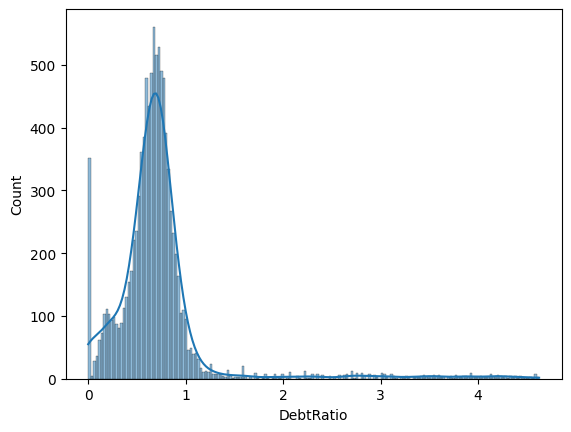

In [63]:
sns.histplot(train_set['DebtRatio'], kde=True)
plt.show()

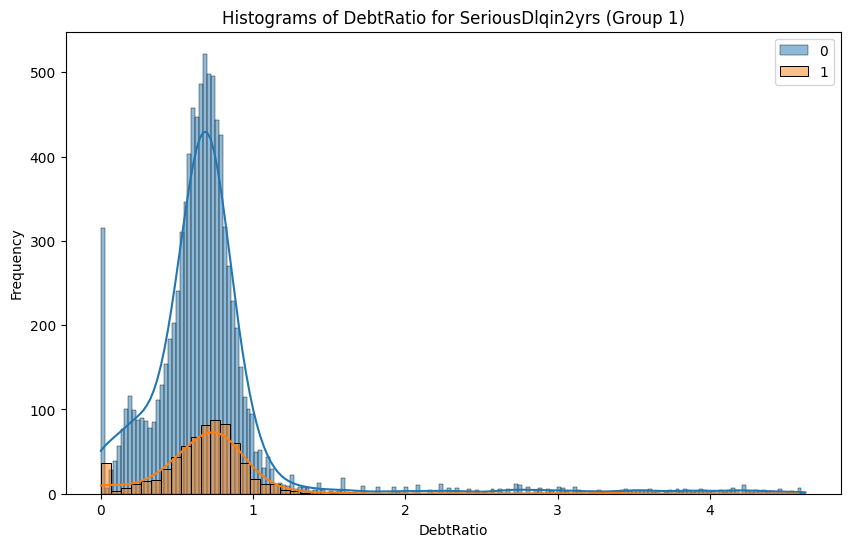

In [64]:
plot_grouped_histograms(train_set, cat_col= target, num_col= "DebtRatio", group_size= 2)

In [65]:
# MonthlyIncome

In [66]:
train_set['MonthlyIncome'].isnull().sum()

571

In [67]:
train_set['MonthlyIncome'].fillna(train_set['MonthlyIncome'].median(), inplace=True)
train_set['MonthlyIncome'].isnull().sum()

0

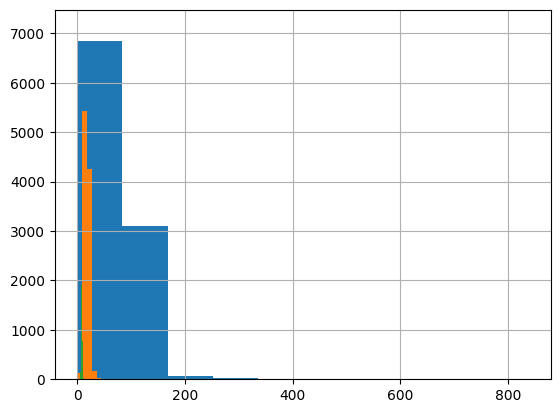

In [68]:
np.sqrt(train_set["MonthlyIncome"]).hist() 
np.cbrt(train_set["MonthlyIncome"]).hist() 
np.log(train_set["MonthlyIncome"] + 1).hist() 
plt.show()

In [69]:
train_set["MonthlyIncome"] = train_set["MonthlyIncome"].apply(lambda x: np.log(x + 1))

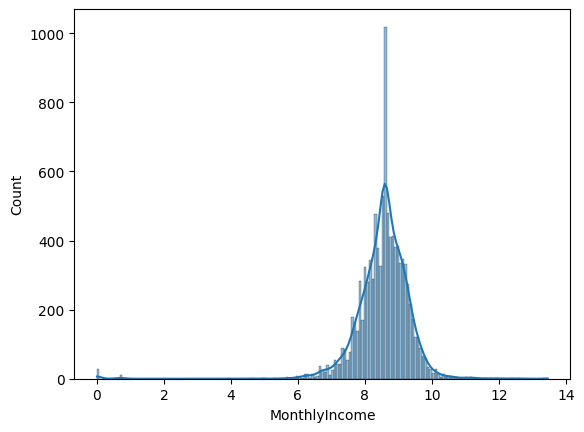

In [70]:
sns.histplot(train_set['MonthlyIncome'], kde=True)
plt.show()

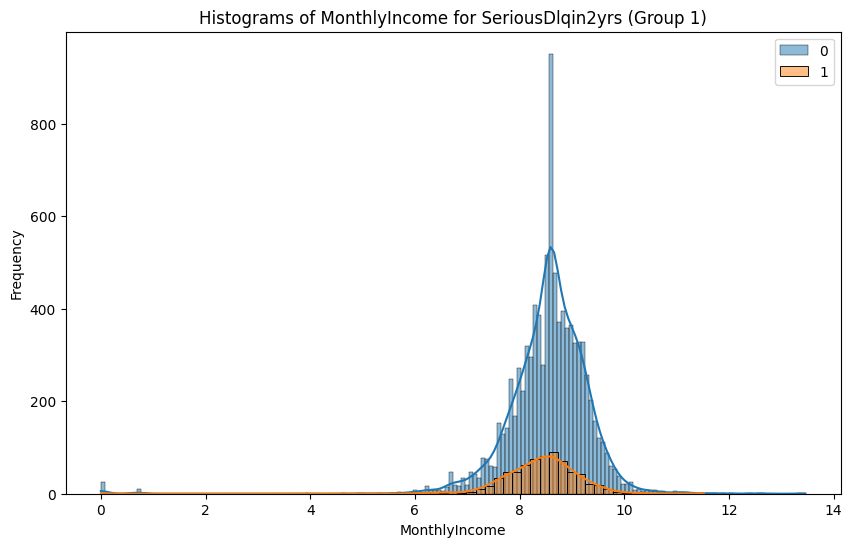

In [71]:
plot_grouped_histograms(train_set, cat_col= target, num_col= "MonthlyIncome", group_size= 2)

**Escalonando**

In [72]:
scaler_num = StandardScaler()
train_set[features_num] = scaler_num.fit_transform(train_set[features_num])

**Aplicando transformaciones a test_set**

In [73]:
test_set['NumberOfDependents']

9525     1.0
2984     1.0
6247     0.0
9931     0.0
7354     0.0
        ... 
2666     0.0
6522     0.0
10692    1.0
8291     1.0
7995     0.0
Name: NumberOfDependents, Length: 2508, dtype: float64

In [74]:
# Categóricas

test_set['age'] = pd.cut(test_set['age'], bins=bins_age, labels=labels_age, right=False)
test_set['NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(test_set['NumberOfTime30-59DaysPastDueNotWorse'], bins=bins_NumberOfTime30_59DaysPastDueNotWorse, labels=labels_NumberOfTime30_59DaysPastDueNotWorse, right=False)
test_set['NumberOfOpenCreditLinesAndLoans'] = pd.cut(test_set['NumberOfOpenCreditLinesAndLoans'], bins=bins_NumberOfOpenCreditLinesAndLoans, labels=labels_NumberOfOpenCreditLinesAndLoans, right=False)
test_set['NumberOfTimes90DaysLate'] = pd.cut(test_set['NumberOfTimes90DaysLate'], bins=bins_NumberOfTimes90DaysLate, labels=labels_NumberOfTimes90DaysLate, right=False)
test_set['NumberRealEstateLoansOrLines'] = pd.cut(test_set['NumberRealEstateLoansOrLines'], bins=bins_NumberRealEstateLoansOrLines,labels=labels_NumberRealEstateLoansOrLines, right=False)
test_set['NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(test_set['NumberOfTime60-89DaysPastDueNotWorse'], bins=bins_NumberOfTime60_89DaysPastDueNotWorse, labels=labels_NumberOfTime60_89DaysPastDueNotWorse,right=False)

test_set['NumberOfDependents'] = pd.cut(test_set['NumberOfDependents'], bins=bins_NumberOfDependents, labels=labels_NumberOfDependents, right=False)
test_set['NumberOfDependents'] = test_set['NumberOfDependents'].cat.add_categories("Unknown")
test_set['NumberOfDependents'].fillna("Unknown", inplace=True)

test_set['age_encoded'] = ordinal_encoder_age.transform(test_set[['age']])
test_set['NumberOfTime30-59DaysPastDueNotWorse_encoded'] = ordinal_encoder_NumberOfTime30_59DaysPastDueNotWorse.transform(test_set[['NumberOfTime30-59DaysPastDueNotWorse']])
test_set['NumberOfOpenCreditLinesAndLoans_encoded'] = ordinal_encoder_NumberOfOpenCreditLinesAndLoans.transform(test_set[['NumberOfOpenCreditLinesAndLoans']])
test_set['NumberOfTimes90DaysLate_encoded'] = ordinal_encoder_NumberOfTimes90DaysLate.transform(test_set[['NumberOfTimes90DaysLate']])
test_set['NumberRealEstateLoansOrLines_encoded'] = ordinal_encoder_NumberRealEstateLoansOrLines.transform(test_set[['NumberRealEstateLoansOrLines']])
test_set['NumberOfTime60-89DaysPastDueNotWorse_encoded'] = ordinal_encoder_NumberOfTime60_89DaysPastDueNotWorse.transform(test_set[['NumberOfTime60-89DaysPastDueNotWorse']])
test_set['NumberOfDependents_encoded'] = ordinal_encoder_NumberOfDependents.transform(test_set[['NumberOfDependents']])

# Numéricas

test_set["RevolvingUtilizationOfUnsecuredLines"] = test_set["RevolvingUtilizationOfUnsecuredLines"].apply(np.cbrt)
test_set["DebtRatio"] = test_set["DebtRatio"].apply(np.cbrt)
test_set['MonthlyIncome'].fillna(train_set['MonthlyIncome'].median(), inplace=True)
test_set["MonthlyIncome"] = test_set["MonthlyIncome"].apply(lambda x: np.log(x + 1))

In [75]:
train_set.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'age_encoded',
       'NumberOfTime30-59DaysPastDueNotWorse_encoded',
       'NumberOfOpenCreditLinesAndLoans_encoded',
       'NumberOfTimes90DaysLate_encoded',
       'NumberRealEstateLoansOrLines_encoded',
       'NumberOfTime60-89DaysPastDueNotWorse_encoded',
       'NumberOfDependents_encoded'],
      dtype='object')

In [76]:
features = ["age_encoded", "NumberOfTime30-59DaysPastDueNotWorse_encoded", "NumberOfOpenCreditLinesAndLoans_encoded", \
"NumberOfTimes90DaysLate_encoded", "NumberRealEstateLoansOrLines_encoded", "NumberOfTime60-89DaysPastDueNotWorse_encoded", "NumberOfDependents_encoded", \
"RevolvingUtilizationOfUnsecuredLines", "DebtRatio", "MonthlyIncome"]

In [77]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

In [78]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10029, 10)
(10029,)
(2508, 10)
(2508,)


**Oversampling con SMOTE**

In [79]:
from imblearn.over_sampling import SMOTE # Nuevos amigos para ayudaros

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [81]:
print(X_train_smote.shape)
print(y_train_smote.shape)
print(X_test.shape)
print(y_test.shape)

(18656, 10)
(18656,)
(2508, 10)
(2508,)


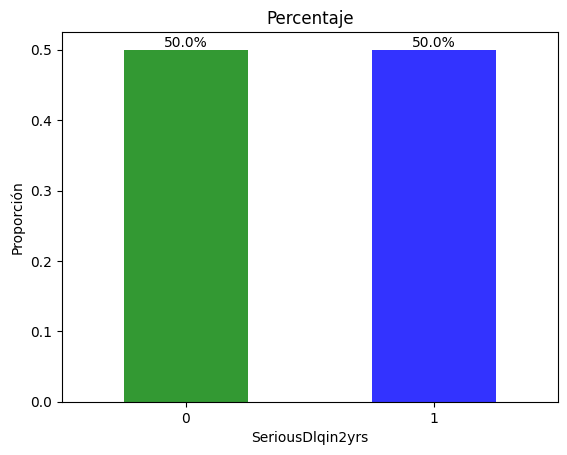

In [87]:
ax = y_train_smote.value_counts(normalize=True).plot(
    kind="bar", color=["green", "blue"], alpha=0.8
)

for p in ax.patches:
    percentage = f"{p.get_height() * 100:.1f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xlabel("SeriousDlqin2yrs")
plt.ylabel("Proporción")
plt.title("Percentaje")
plt.xticks(rotation=0)
plt.show()

### LogisticRegression

In [ ]:
# Oversampled

modelo_smote = LogisticRegression(random_state=42, max_iter = 25000)
modelo_smote.fit(X_train_smote, y_train_smote)

# Unbalanced

modelo_unbalanced = LogisticRegression(random_state=42, max_iter = 25000)
modelo_unbalanced.fit(X_train, y_train)

# Modelo_SMOTE
y_pred_smote = modelo_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2345
           1       0.30      0.51      0.37       163

    accuracy                           0.89      2508
   macro avg       0.63      0.71      0.66      2508
weighted avg       0.92      0.89      0.90      2508



In [90]:
# Modelo_UNBALANCED
y_pred = modelo_unbalanced.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2345
           1       0.70      0.10      0.17       163

    accuracy                           0.94      2508
   macro avg       0.82      0.55      0.57      2508
weighted avg       0.92      0.94      0.92      2508



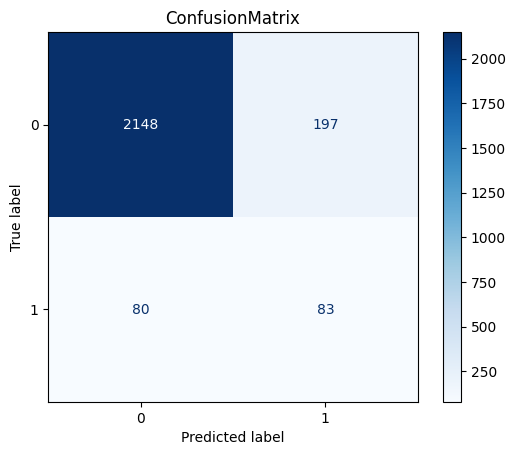

In [91]:
cm = confusion_matrix(y_test, y_pred_smote)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='d')  # values_format='d' exibe os valores como inteiros
plt.title('ConfusionMatrix')
plt.show()

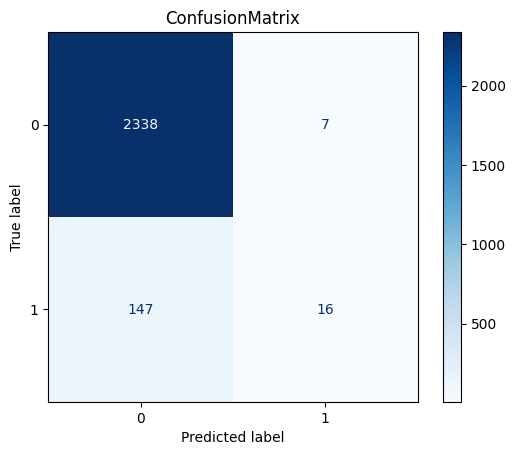

In [92]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='d') 
plt.title('ConfusionMatrix')
plt.show()

### KNN

In [98]:
knn = KNeighborsClassifier(n_neighbors=40)

knn.fit(X_train_smote,y_train_smote)

y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2345
           1       0.24      0.20      0.21       163

    accuracy                           0.91      2508
   macro avg       0.59      0.58      0.58      2508
weighted avg       0.90      0.91      0.90      2508



In [100]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],           
    'weights': ['uniform', 'distance'],     
    'p': [1, 2],                             
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40]        
}

grid_search = GridSearchCV(
    estimator=knn,             
    param_grid=param_grid,      
    cv=5,                    
    n_jobs=-1,                
    verbose=1,                
    scoring='recall'         
)

grid_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=40), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 30, 40],
                         'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15, 20], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=1)

In [102]:
grid_search.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 9,
 'p': 2,
 'weights': 'distance'}

In [103]:
best_knn = grid_search.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)
print(classification_report(y_test, y_pred_best_knn))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2345
           1       0.15      0.15      0.15       163

    accuracy                           0.89      2508
   macro avg       0.54      0.55      0.54      2508
weighted avg       0.89      0.89      0.89      2508



### Ensamblados

In [104]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)

In [128]:
# RandomForest

In [108]:
params_grid_rf = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [2, 5, 10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid_rf,
                       cv = 5,
                       scoring = "balanced_accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [2, 5, 10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='balanced_accuracy')

In [109]:
rf_grid.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.6,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [110]:
best_rf = rf_grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2345
           1       0.33      0.42      0.37       163

    accuracy                           0.91      2508
   macro avg       0.64      0.68      0.66      2508
weighted avg       0.92      0.91      0.91      2508



In [ ]:
# XGBoost

In [116]:
xgb_params_random = {
    "n_estimators": [100, 200, 400],
    "max_depth": [2, 4, 10],
    "min_child_weight": [2, 5, 10],  
    "colsample_bytree": [0.3, 0.6, 1], 
    "subsample": [0.3, 0.6, 1] 
}

xgb_clf = XGBClassifier()


xgb_clf_random = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_params_random, 
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    n_iter=10,  
    random_state=42  #
)

xgb_clf_random.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.6, 1],
                                        'max_depth': [2, 4, 10],
                                        'min_child_weight': [2, 5, 10],
                                        'n_estimators': [100, 200, 400],
                                        'subsample': [0.3, 0.6, 1]},
                   random_state=42, scoring='balanced_accuracy')

In [117]:
xgb_clf_random.best_params_

{'subsample': 0.6,
 'n_estimators': 400,
 'min_child_weight': 5,
 'max_depth': 10,
 'colsample_bytree': 1}

In [118]:
best_xgb = xgb_clf_random.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_best_xgb))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2345
           1       0.26      0.28      0.27       163

    accuracy                           0.90      2508
   macro avg       0.61      0.61      0.61      2508
weighted avg       0.91      0.90      0.90      2508



### GridSearch con LogisticRegression

In [119]:
param_grid_lr = {
    "penalty": ["l1", "l2", "elasticnet", None],  
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  
    "solver": ["liblinear", "lbfgs", "saga"], 
    "max_iter": [100, 500, 1000]  
}

log_reg = LogisticRegression()

grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5, 
    scoring="recall",  
    n_jobs=-1, 
    verbose=1  
)

grid_search_lr.fit(X_train_smote, y_train_smote)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='recall', verbose=1)

In [120]:
grid_search_lr.best_params_

{'C': 0.001, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}

In [124]:
best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test)
print(classification_report(y_test, y_pred_best_lr))

              precision    recall  f1-score   support

           0       0.98      0.59      0.74      2345
           1       0.13      0.84      0.22       163

    accuracy                           0.61      2508
   macro avg       0.55      0.72      0.48      2508
weighted avg       0.93      0.61      0.71      2508



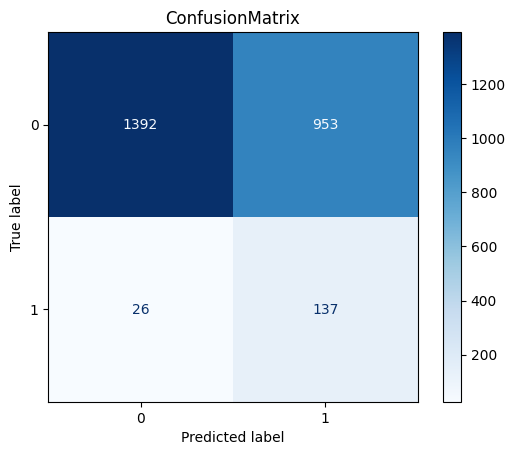

In [125]:
cm = confusion_matrix(y_test, y_pred_best_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='d') 
plt.title('ConfusionMatrix')
plt.show()